In [1]:
import argparse
import numpy as np
from get_data import main
from cnn.training import get_trained_model
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from utils.accuracy import mono_label
from knn.knn import KNN, visu_acc_knn
from utils.features import normalize_features
#from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
#plt.style.use('ggplot')

In [8]:
!pip install hyperopt

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help='Path to the config file', default='./default_config.yml')
parser.add_argument('--log-dir', help='Path to the log directory', default='../log/')
parser.add_argument('--posters', help='Path to the posters', default='../data/posters/')
parser.add_argument('--models-dir', help='Path to the saved models', default='../data/models/')
parser.add_argument('--sets-dir', help='Path to the training and testing sets', default='../data/sets/')
parser.add_argument('--database', help='Path to the databse csv', default='../data/poster_data.csv')
parser.add_argument('--csv', help='Path to the clean csv', default='../data/')
parser.add_argument('-s', '--save', help='Save model', action='store_true')
parser.add_argument('-v', '--verbose', help='Verbose', action='store_true')

str_args = '-v -s'.split()
args, _ = parser.parse_known_args(str_args)

In [3]:
clean_movies, train_posters, train_genres, train_ids, test_posters, test_genres, test_ids, model_name, save_model, verbose = main(args)

  1%|▉                                                                           | 153/11935 [00:00<00:07, 1522.72it/s]

Database already cleaned
Posters database downloading


 82%|█████████████████████████████████████████████████████████████▎             | 9756/11935 [00:06<00:01, 1510.20it/s]

Error HTTP Error 404: Not Found with film 9532


100%|██████████████████████████████████████████████████████████████████████████| 11935/11935 [00:08<00:00, 1435.01it/s]


Database downloaded
Training and testing sets already made


# Features

ResNet

In [5]:
resnet, _ = get_trained_model(model_name)

Loading keras ResNet50V2


In [6]:
train_features_resnet = resnet.predict(train_posters).reshape((len(train_posters), -1))
test_features_resnet = resnet.predict(test_posters).reshape((len(test_posters), -1))

Posters bruts

In [4]:
# Normalisation 
train_posters_norm, test_posters_norm = normalize_features(train_posters, test_posters)
# Redimensionnement pour kNN
train_posters_norm = np.reshape( train_posters_norm, (len(train_posters), (100*100*3)))
test_posters_norm = np.reshape(test_posters_norm, (len(test_posters), 100*100*3))
print(train_posters_norm.shape)
print(test_posters_norm.shape)


(4165, 30000)
(734, 30000)


# PCA

In [7]:
from sklearn.decomposition import PCA

pca_resnet = PCA(n_components=0.95)

In [8]:
from sklearn.preprocessing import StandardScaler

SC = StandardScaler()
SC.fit(train_features_resnet)
train_features_resnet_stand = SC.transform(train_features_resnet)
test_features_resnet_stand = SC.transform(test_features_resnet)

In [9]:
pca_resnet.fit(train_features_resnet)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
train_resnet_pca = pca_resnet.transform(train_features_resnet)
test_resnet_pca = pca_resnet.transform(test_features_resnet)

#train_resnet_pca = pca_resnet.transform(train_features_resnet_stand)
#test_resnet_pca = pca_resnet.transform(test_features_resnet_stand)

In [10]:
print(train_features_resnet.shape[1], train_resnet_pca.shape[1])

32768 2178


# KNN 

In [11]:
k = 3
knn = KNN(k)
knn.fit(train_posters_norm, train_genres)

KNN(n_neighbors=3, verbose=True, weights='distance')

In [25]:
predicted_genres = knn.predict(test_posters_norm, train_genres)
acc = mono_label(test_genres, predicted_genres)
print('Accuracy:', acc)

label_for_max [[[0.         0.         0.         3.20039078 0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         3.14728978
   0.        ]
  [0.         0.         0.         0.         3.03451914 0.
   0.        ]]]
distances [[0.31246184 0.31773369 0.3295415 ]]
neighbors [[ 801 3617 3696]]
label_for_max [[[0.         2.4265608  0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         2.40786297 0.
   0.        ]
  [0.         0.         0.         0.         2.36777741 0.
   0.        ]]]
distances [[0.41210589 0.41530603 0.422337  ]]
neighbors [[1667 3306 3096]]
label_for_max [[[0.         0.         0.         2.2061881  0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         2.07278422
   0.        ]
  [1.94606854 0.         0.         0.         0.         0.
   0.        ]]]
distances [[0.45327051 0.48244289 0.51385652]]
neighbors [[3206 1033 2747]]
label_for_max [[[0.     

label_for_max [[[0.         0.         0.         0.         0.         0.
   2.02541929]
  [0.         1.98397857 0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         1.97493782 0.         0.
   0.        ]]]
distances [[0.49372493 0.5040377  0.50634506]]
neighbors [[ 546 1026 2449]]
label_for_max [[[3.59140017 0.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         0.
   3.5019803 ]
  [0.         0.         0.         0.         3.45130006 0.
   0.        ]]]
distances [[0.27844293 0.28555272 0.28974589]]
neighbors [[1751  242  133]]
label_for_max [[[0.         0.         0.         2.67844501 0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         2.66348988
   0.        ]
  [0.         0.         2.65805968 0.         0.         0.
   0.        ]]]
distances [[0.37335095 0.37544727 0.37621428]]
neighbors [[3435 2653  560]]
label_for_max [[[0.         0.  

C:\Users\viniv\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\viniv\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


label_for_max [[[       nan        nan        nan        nan        nan        inf
          nan]
  [0.         0.         0.         0.         1.21228869 0.
   0.        ]
  [0.         0.         0.         0.         0.         1.21183099
   0.        ]]]
distances [[0.         0.82488602 0.82519758]]
neighbors [[2618 1392 4060]]
label_for_max [[[0.         0.         0.         0.         0.         1.32688516
   0.        ]
  [1.31625088 0.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         1.30305535 0.
   0.        ]]]
distances [[0.75364472 0.75973359 0.76742711]]
neighbors [[3568 3928 1767]]
label_for_max [[[0.         0.         0.         0.         0.         2.69854935
   0.        ]
  [0.         2.66655335 0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         2.61458997
   0.        ]]]
distances [[0.37056947 0.37501594 0.38246915]]
neighbors [[3617  561 3369]]


KeyboardInterrupt: 

# XGBoost

Lien pour avoir accès à la courbe de loss : https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [ ]:
from xgboost import XGBClassifier, plot_tree

train_genres_flat = np.array([np.nonzero(x)[0] for x in train_genres]).squeeze()
test_genres_flat = np.array([np.nonzero(x)[0] for x in test_genres]).squeeze()

Le bloc suivant calcule le classifier optimal sur la search grid optimal:

pour les hyperparamètres de base :https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

In [1]:
boost = XGBClassifier(objective='multi:softmax', num_classes=7)
boost.fit(train_resnet_pca, train_genres_flat, eval_metric=["merror", "mlogloss"], eval_set=[(train_resnet_pca, train_genres_flat), (test_resnet_pca, test_genres_flat)])

train_genres_flat = np.array([np.nonzero(x)[0] for x in train_genres]).squeeze()
test_genres_flat = np.array([np.nonzero(x)[0] for x in test_genres]).squeeze()


def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            num_classes=7
                            )
    
    classifier.fit(train_resnet_pca, train_genres_flat)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = train_resnet_pca, y = train_genres_flat, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(3, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

#space = {
#    'max_depth' : hp.choice('max_depth', range(4, 5, 1)),
#    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.03, 0.01),
#    'n_estimators' : hp.choice('n_estimators', range(90, 105, 5)),
#    'gamma' : hp.quniform('gamma', 0.9, 0.92, 0.01),
#    'min_child_weight' : hp.quniform('min_child_weight', 1, 3, 1),
#    'subsample' : hp.quniform('subsample', 0.8, 0.82, 0.01),
#    'colsample_bytree' : hp.quniform('colsample_bytree', 0.9, 0.92, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)

NameError: name 'XGBClassifier' is not defined

In [ ]:
# Fitting XGBoost to the Training set
boost = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree'],
                            num_classes=7
                     )

boost.fit(train_resnet_pca, train_genres_flat, eval_metric=["merror", "mlogloss"], eval_set=[(train_resnet_pca, train_genres_flat), (test_resnet_pca, test_genres_flat)])

Si on veut calculer un arbre sans l'optimisation des hyperparamètres.

In [ ]:
boost = XGBClassifier(objective='multi:softmax', num_classes=7)
boost.fit(train_resnet_pca, train_genres_flat, eval_metric=["merror", "mlogloss"], eval_set=[(train_resnet_pca, train_genres_flat), (test_resnet_pca, test_genres_flat)])

In [ ]:
predicted_genres = boost.predict(test_resnet_pca)
test_genres_flat = np.array([np.nonzero(x)[0] for x in test_genres]).squeeze()

In [ ]:
# retrieve performance metrics
results = boost.evals_result()
epochs = len(results['validation_0']['merror'])
print(epochs)
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
# plot log loss
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.grid("True")
ax.legend()
plt.show()


# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.grid("True")
ax.legend()
plt.show()

#### performance

In [ ]:
boost.save_model('current.model')
print("accuracy : ", np.mean(test_genres_flat == predicted_genres))

In [ ]:
predicted_genres_matrix = np.zeros((len(predicted_genres), 7))
for i in range(len(predicted_genres)):
    predicted_genres_matrix[i][predicted_genres[i]] = 1

In [ ]:
ConfusionMatrix_display(test_genres, predicted_genres_matrix, config['genres'], "Performance du random_forest")

#### features d'intérêt

In [ ]:
plt.bar(range(len(boost.feature_importances_)), boost.feature_importances_)
plt.show()
print(np.sum(boost.feature_importances_))

#### Affichage de l'arbre

In [ ]:
plot_tree(boost)
fig = plt.gcf()
fig.set_size_inches(300, 150)

#double click pour la visualisation

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier # Regarder les autres multiclass possibles
# J'ai testé vite fait OneVsOne: pb de dimension, autre format d'input attendu

svc = OneVsRestClassifier(SVC(gamma='auto'))
svc.fit(train_resnet_pca, train_genres)

In [ ]:
predicted_genres = svc.predict(test_resnet_pca)
acc = mono_label(test_genres, predicted_genres)

# Analyse des résultats

In [22]:
import yaml

config = yaml.safe_load(open(args.config))
class_names = {config['genres'][k]: k for k in config['genres'].keys()}

['Action', 'Animation', 'ComÃ©die', 'ComÃ©die dramatique', 'Documentaire', 'Drame', 'Thriller-Policier']


array([[0.8605042 , 0.03529412, 0.02857143, 0.00672269, 0.02184874,
        0.01512605, 0.03193277],
       [0.0907563 , 0.84033613, 0.01848739, 0.01176471, 0.02521008,
        0.00840336, 0.00504202],
       [0.10084034, 0.19495798, 0.6302521 , 0.02521008, 0.02184874,
        0.01344538, 0.01344538],
       [0.1210084 , 0.18319328, 0.14957983, 0.46890756, 0.04369748,
        0.02016807, 0.01344538],
       [0.11596639, 0.17478992, 0.09915966, 0.0907563 , 0.47731092,
        0.01848739, 0.02352941],
       [0.13445378, 0.16302521, 0.11932773, 0.1210084 , 0.08739496,
        0.34789916, 0.02689076],
       [0.17647059, 0.13613445, 0.13109244, 0.11260504, 0.11260504,
        0.03193277, 0.29915966]])

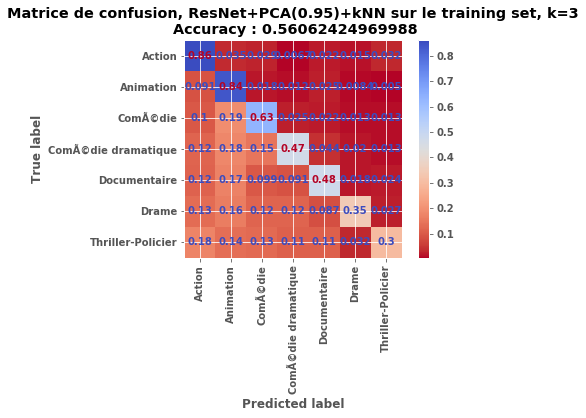

In [30]:
from utils.display.results_display import ConfusionMatrix_display

title = 'ResNet+PCA(0.95)+kNN, k='+str(k)+'\n Accuracy : '+ str(acc)
ConfusionMatrix_display(test_genres, predicted_genres, config['genres'], title)

In [21]:
from utils.display.results_display import histogram

histogram(test_genres, predicted_genres, k, config['genres'])

NameError: name 'config' is not defined

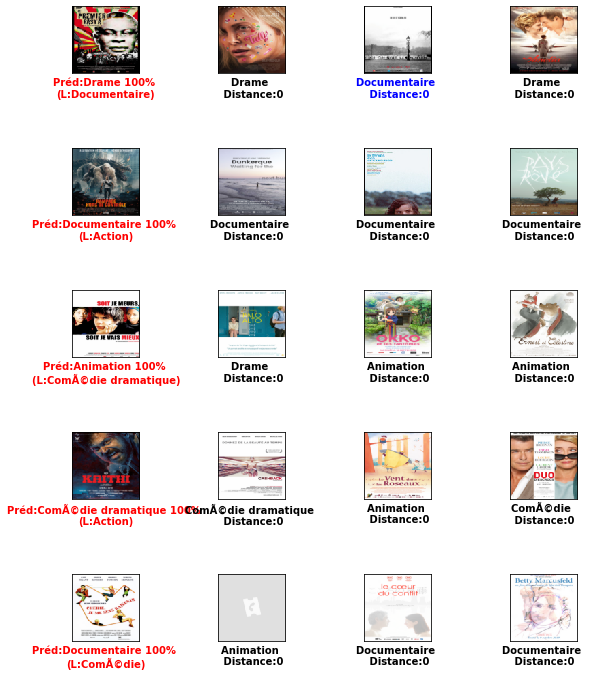

In [23]:
from utils.display.results_display import plot_neighbors
%matplotlib inline

starting_index = np.random.randint(0, 700)
num_images = 5
plot_neighbors(test_posters, test_genres, class_names, predicted_genres, starting_index, num_images, train_posters, train_genres, knn.neighbors, knn.distances, method_for_title='ResNet+kNN')
#plot_neighbors(train_posters, train_genres, class_names, predicted_genres, starting_index, num_images, train_posters, train_genres, knn.neighbors, knn.distances, method_for_title='')

  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:17<06:58,  1.68it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|███████                                                                          | 64/734 [00:36<06:27,  1.73it/s]


 18%|██████████████▏                                                                 | 130/734 [01:14<05:56,  1.69it/s]


 27%|█████████████████████▎                                                          | 196/734 [01:53<05:20,  1.68it/s]


 36%|████████████████████████████▌                                                   | 262/734 [02:31<04:23,  1.79it/s]


 45%|███████████████████████████████████▋                                            | 328/734 [03:09<03:54,  1.73it/s]


 54%|██████████████████████████████████████████▉                                     | 394/734 [03:35<01:14,  4.57it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [03:44<01:06,  4.48it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▉                              | 458/734 [03:49<01:03,  4.32it/s]


 71%|█████████████████████████████████████████████████████████                       | 524/734 [04:04<00:48,  4.35it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 590/734 [04:19<00:31,  4.57it/s]


 89%|███████████████████████████████████████████████████████████████████████▍        | 656/734 [04:36<00:30,  2.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 730/734 [04:58<00:01,  3.23it/s]


  3%|██▋                                                                             | 1/30 [06:08<2:57:55, 368.13s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:08<03:59,  2.94it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:19<03:35,  3.11it/s]


 18%|██████████████                                                                  | 129/734 [00:40<02:55,  3.45it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:59<02:26,  3.67it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:18<02:18,  3.41it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:38<02:08,  3.17it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:58<01:41,  3.37it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [02:12<01:36,  3.09it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [02:18<01:27,  3.16it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:39<01:08,  3.10it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [03:00<00:45,  3.24it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [03:18<00:21,  3.72it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [03:38<00:03,  3.68it/s]


  7%|█████▎                                                                          | 2/30 [10:32<2:37:17, 337.04s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:08<03:22,  3.48it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:15<02:32,  4.40it/s]


 18%|██████████████                                                                  | 129/734 [00:30<02:15,  4.47it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:45<02:02,  4.40it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:00<01:44,  4.50it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:16<01:41,  4.02it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:31<01:14,  4.58it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:40<01:05,  4.60it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:45<01:02,  4.42it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:00<00:49,  4.28it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:14<00:31,  4.58it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:29<00:17,  4.54it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:44<00:03,  4.30it/s]


 10%|████████                                                                        | 3/30 [13:52<2:13:11, 295.98s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:41,  4.35it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:31,  4.44it/s]


 18%|██████████████                                                                  | 129/734 [00:28<02:15,  4.46it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:43<02:03,  4.35it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:58<01:41,  4.66it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:29,  4.57it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:27<01:15,  4.52it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:37<01:05,  4.53it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:41<01:03,  4.39it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:57<01:00,  3.52it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:12<00:32,  4.51it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:27<00:17,  4.45it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:42<00:03,  4.47it/s]


 13%|██████████▋                                                                     | 4/30 [17:05<1:54:52, 265.11s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:44,  4.28it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:41,  4.16it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:15,  4.46it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:31,  3.56it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:00<01:43,  4.57it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:15<01:30,  4.50it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:29<01:14,  4.57it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:39<01:05,  4.54it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:02,  4.43it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:58<00:49,  4.31it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:16<00:33,  4.32it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:31<00:18,  4.44it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:46<00:03,  3.59it/s]


 17%|█████████████▎                                                                  | 5/30 [20:23<1:42:01, 244.85s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:43,  4.32it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:32,  4.39it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:17,  4.39it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:04,  4.35it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:41,  4.67it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:30,  4.48it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:31<01:37,  3.49it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:42<01:08,  4.35it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:47<01:06,  4.18it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:03<00:50,  4.22it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:18<00:33,  4.42it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:33<00:18,  4.44it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:48<00:03,  4.21it/s]


 20%|████████████████                                                                | 6/30 [23:43<1:32:33, 231.38s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:07<03:17,  3.57it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:15<03:09,  3.55it/s]


 18%|██████████████                                                                  | 129/734 [00:32<02:19,  4.35it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:51<03:05,  2.90it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:07<01:41,  4.66it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:22<01:33,  4.37it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:37<01:15,  4.50it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:48<01:10,  4.22it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:52<01:05,  4.28it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:09<00:59,  3.59it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:25<00:31,  4.58it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:39<00:17,  4.51it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:54<00:03,  4.46it/s]


 23%|██████████████████▋                                                             | 7/30 [27:07<1:25:36, 223.32s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:39,  4.42it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:31,  4.42it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:41,  3.74it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:48<02:27,  3.66it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:04<01:43,  4.57it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:19<01:39,  4.08it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:37<01:24,  4.05it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:47<01:08,  4.36it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:53<01:24,  3.28it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:17<01:08,  3.11it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:38<00:46,  3.15it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:58<00:19,  4.13it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [03:14<00:03,  4.12it/s]


 27%|█████████████████████▎                                                          | 8/30 [30:52<1:22:00, 223.68s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:07<03:02,  3.86it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:15<02:47,  4.01it/s]


 18%|██████████████                                                                  | 129/734 [00:32<02:38,  3.83it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:50<02:21,  3.82it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:09<02:00,  3.92it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:26<01:49,  3.70it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:43<01:34,  3.60it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:54<01:16,  3.91it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [02:00<01:11,  3.86it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:17<00:57,  3.66it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:34<00:37,  3.85it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:51<00:20,  3.92it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [03:10<00:03,  3.84it/s]


 30%|████████████████████████                                                        | 9/30 [34:36<1:18:18, 223.73s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:08<03:00,  3.89it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:16<02:40,  4.18it/s]


 18%|██████████████                                                                  | 129/734 [00:31<02:17,  4.41it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:48<02:03,  4.36it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:03<01:46,  4.45it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:23<01:43,  3.91it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:40<01:14,  4.57it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:49<01:05,  4.54it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:54<01:06,  4.20it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:10<00:59,  3.54it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:26<00:33,  4.41it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:41<00:18,  4.43it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:56<00:03,  4.37it/s]


 33%|██████████████████████████▎                                                    | 10/30 [38:09<1:13:28, 220.43s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:41,  4.37it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:29,  4.50it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:17,  4.41it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:05,  4.28it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:44,  4.53it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:30,  4.51it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:28<01:14,  4.55it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:38<01:19,  3.78it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:09,  3.99it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:59<00:52,  4.05it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:15<00:38,  3.82it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:32<00:20,  3.92it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:49<00:03,  3.95it/s]


 37%|████████████████████████████▉                                                  | 11/30 [41:30<1:07:59, 214.70s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:08<02:52,  4.08it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:17<03:48,  2.93it/s]


 18%|██████████████                                                                  | 129/734 [00:33<02:20,  4.31it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:49<01:59,  4.50it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:04<01:43,  4.55it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:19<01:30,  4.52it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:36<01:27,  3.90it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:46<01:06,  4.52it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:51<01:03,  4.36it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:06<00:50,  4.21it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:22<00:39,  3.67it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:40<00:19,  4.07it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:55<00:03,  3.87it/s]


 40%|███████████████████████████████▌                                               | 12/30 [44:56<1:03:40, 212.26s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:07<02:42,  4.32it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:37,  4.26it/s]


 18%|██████████████                                                                  | 129/734 [00:30<02:19,  4.34it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:46<02:03,  4.38it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:03<02:36,  3.02it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:20<01:30,  4.51it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:36<01:16,  4.49it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:45<01:11,  4.17it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:50<01:02,  4.42it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:05<00:53,  3.97it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:21<00:34,  4.23it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:36<00:17,  4.53it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:51<00:03,  3.63it/s]


 43%|███████████████████████████████████                                              | 13/30 [48:20<59:22, 209.56s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:07<02:57,  3.96it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:15<02:48,  3.99it/s]


 18%|██████████████                                                                  | 129/734 [00:32<02:31,  4.00it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:47<02:02,  4.40it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:02<01:42,  4.64it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:16<01:29,  4.57it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:32<01:16,  4.43it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:41<01:05,  4.58it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:46<01:01,  4.51it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:01<00:49,  4.30it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:16<00:32,  4.49it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:30<00:17,  4.54it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:45<00:03,  4.47it/s]


 47%|█████████████████████████████████████▊                                           | 14/30 [51:38<54:58, 206.15s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:39,  4.41it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:15<03:16,  3.41it/s]


 18%|██████████████                                                                  | 129/734 [00:30<02:13,  4.52it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:45<02:00,  4.48it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:41,  4.68it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:14<01:30,  4.51it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:28<01:13,  4.63it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:38<01:07,  4.43it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:02,  4.45it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:57<00:50,  4.17it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:15<00:44,  3.31it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:31<00:17,  4.57it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:45<00:03,  4.43it/s]


 50%|████████████████████████████████████████▌                                        | 15/30 [54:53<50:44, 202.96s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:41,  4.37it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:33,  4.36it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:19,  4.33it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:45<02:05,  4.28it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:02<01:50,  4.27it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:17<01:34,  4.29it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:32<01:17,  4.41it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:42<01:12,  4.12it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:47<01:05,  4.23it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:02<00:48,  4.35it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:17<00:33,  4.35it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:32<00:19,  4.14it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:47<00:03,  4.49it/s]


 53%|███████████████████████████████████████████▏                                     | 16/30 [58:11<46:58, 201.31s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:42,  4.33it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:32,  4.41it/s]


 18%|██████████████                                                                  | 129/734 [00:28<02:16,  4.44it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:08,  4.19it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:48,  4.37it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:14<01:29,  4.53it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:29<01:14,  4.59it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:39<01:23,  3.56it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:44<01:10,  3.93it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:59<00:48,  4.36it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:15<00:32,  4.46it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:30<00:17,  4.58it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:45<00:03,  4.45it/s]


 57%|████████████████████████████████████████████▊                                  | 17/30 [1:01:28<43:19, 199.94s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:40,  4.38it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:31,  4.44it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:25,  4.17it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:45<02:00,  4.46it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:00<01:45,  4.48it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:15<01:32,  4.39it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:30<01:13,  4.64it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:40<01:05,  4.54it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:44<01:02,  4.45it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:59<00:49,  4.32it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:13<00:32,  4.55it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:29<00:19,  4.16it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:44<00:03,  4.51it/s]


 60%|███████████████████████████████████████████████▍                               | 18/30 [1:04:42<39:38, 198.19s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:41,  4.36it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:32,  4.40it/s]


 18%|██████████████                                                                  | 129/734 [00:28<02:13,  4.53it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:43<02:02,  4.39it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:58<01:41,  4.65it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:14<01:32,  4.41it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:29<01:13,  4.62it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:38<01:04,  4.62it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:01,  4.49it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:57<00:48,  4.37it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:12<00:33,  4.42it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:27<00:17,  4.48it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:42<00:03,  4.43it/s]


 63%|██████████████████████████████████████████████████                             | 19/30 [1:07:53<35:58, 196.22s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:56,  3.99it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:32,  4.41it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:15,  4.47it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:01,  4.43it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:40,  4.69it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:31,  4.47it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:28<01:13,  4.64it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:37<01:04,  4.63it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:42<01:00,  4.57it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:58<00:59,  3.54it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:13<00:31,  4.56it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:28<00:17,  4.51it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:43<00:03,  4.23it/s]


 67%|████████████████████████████████████████████████████▋                          | 20/30 [1:11:08<32:37, 195.79s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:40,  4.40it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:32,  4.41it/s]


 18%|██████████████                                                                  | 129/734 [00:28<02:14,  4.51it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:29,  3.60it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:41,  4.65it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:14<01:31,  4.44it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:29<01:14,  4.59it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:38<01:08,  4.37it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:05,  4.26it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:58<00:49,  4.29it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:13<00:32,  4.50it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:27<00:17,  4.52it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:43<00:03,  3.61it/s]


 70%|███████████████████████████████████████████████████████▎                       | 21/30 [1:14:21<29:15, 195.01s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]


Predicting...


  4%|███▎                                                                             | 30/734 [00:07<02:48,  4.17it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:29,  4.48it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:19,  4.34it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:44<02:02,  4.41it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:41,  4.68it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:29,  4.54it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:29<01:29,  3.82it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:39<01:05,  4.57it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:01,  4.50it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:58<00:49,  4.25it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:13<00:31,  4.57it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:27<00:17,  4.54it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:42<00:03,  4.49it/s]


 73%|█████████████████████████████████████████████████████████▉                     | 22/30 [1:17:34<25:54, 194.37s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:42,  4.32it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<03:04,  3.64it/s]


 18%|██████████████                                                                  | 129/734 [00:30<02:15,  4.47it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:45<02:00,  4.46it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:59<01:40,  4.70it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:14<01:30,  4.48it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:28<01:14,  4.61it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:38<01:05,  4.60it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:43<01:09,  3.98it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:57<00:48,  4.35it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:12<00:31,  4.58it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:28<00:17,  4.57it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:43<00:03,  4.39it/s]


 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [1:20:48<22:39, 194.28s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:41,  4.37it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:13<02:29,  4.49it/s]


 18%|██████████████                                                                  | 129/734 [00:28<02:14,  4.50it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:43<02:02,  4.41it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:57<01:42,  4.61it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:29,  4.56it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:28<01:14,  4.61it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:38<01:04,  4.60it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:42<01:12,  3.82it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:57<00:49,  4.27it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:12<00:31,  4.61it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:26<00:17,  4.57it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:41<00:03,  4.49it/s]


 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [1:24:00<19:20, 193.39s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:07<02:40,  4.40it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:32,  4.39it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:13,  4.52it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:43<01:59,  4.50it/s]


 36%|████████████████████████████▍                                                   | 261/734 [00:58<01:42,  4.64it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:13<01:28,  4.60it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:27<01:13,  4.65it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:36<01:05,  4.54it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:41<01:02,  4.42it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [01:57<00:51,  4.15it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:12<00:32,  4.56it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:26<00:17,  4.56it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [02:41<00:03,  4.49it/s]


 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [1:27:12<16:06, 193.22s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:06<02:39,  4.40it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:14<02:53,  3.86it/s]


 18%|██████████████                                                                  | 129/734 [00:29<02:14,  4.50it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:45<02:06,  4.26it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:00<01:41,  4.65it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:19<01:54,  3.56it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:36<01:22,  4.11it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:50<01:41,  2.94it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:55<01:21,  3.39it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:13<00:54,  3.89it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:32<00:38,  3.76it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:51<00:22,  3.63it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [03:09<00:04,  3.21it/s]


 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [1:30:52<13:24, 201.19s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:07<03:15,  3.60it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:17<03:03,  3.65it/s]


 18%|██████████████                                                                  | 129/734 [00:35<02:49,  3.58it/s]


 27%|█████████████████████▎                                                          | 195/734 [00:54<02:47,  3.22it/s]


 36%|████████████████████████████▍                                                   | 261/734 [01:11<01:49,  4.30it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [01:27<01:35,  4.27it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [01:43<01:26,  3.92it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [01:54<01:13,  4.07it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [01:59<01:09,  3.99it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [02:16<00:49,  4.32it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [02:31<00:33,  4.34it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [02:47<00:19,  4.15it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [03:03<00:03,  4.35it/s]


 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [1:34:33<10:21, 207.11s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:17<07:06,  1.65it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:36<05:43,  1.95it/s]


 18%|██████████████                                                                  | 129/734 [01:12<05:50,  1.73it/s]


 27%|█████████████████████▎                                                          | 195/734 [01:49<04:53,  1.84it/s]


 36%|████████████████████████████▍                                                   | 261/734 [02:22<03:28,  2.27it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [02:56<03:58,  1.70it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [03:32<03:15,  1.74it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [03:57<02:52,  1.73it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [04:09<02:44,  1.69it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [04:48<02:07,  1.66it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [05:26<01:24,  1.73it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [06:05<00:45,  1.74it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [06:43<00:08,  1.65it/s]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [1:42:26<09:33, 286.74s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:17<07:20,  1.60it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:36<06:39,  1.68it/s]


 18%|██████████████                                                                  | 129/734 [01:15<05:51,  1.72it/s]


 27%|█████████████████████▎                                                          | 195/734 [01:53<05:15,  1.71it/s]


 36%|████████████████████████████▍                                                   | 261/734 [02:31<04:23,  1.80it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [03:09<03:51,  1.76it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [03:47<03:12,  1.77it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [04:11<02:50,  1.76it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [04:23<02:41,  1.72it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [05:01<02:12,  1.59it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [05:39<01:24,  1.73it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [06:18<00:46,  1.71it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [06:57<00:07,  1.79it/s]


 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [1:50:39<05:48, 348.82s/it]

Prediction done



  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Predicting...



  4%|███▎                                                                             | 30/734 [00:19<08:20,  1.41it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

  9%|██████▉                                                                          | 63/734 [00:41<07:56,  1.41it/s]


 18%|██████████████                                                                  | 129/734 [01:23<06:46,  1.49it/s]


 27%|█████████████████████▎                                                          | 195/734 [02:05<05:32,  1.62it/s]


 36%|████████████████████████████▍                                                   | 261/734 [02:48<05:02,  1.57it/s]


 45%|███████████████████████████████████▋                                            | 327/734 [03:31<04:30,  1.51it/s]


 54%|██████████████████████████████████████████▊                                     | 393/734 [04:13<03:39,  1.55it/s]


 59%|███████████████████████████████████████████████▍                                | 435/734 [04:41<03:06,  1.60it/s]C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: divide by zero encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]
C:\Users\viniv\OneDrive\Bureau\Projet_departement\moviegenre\knn\knn.py:26: RuntimeWarning: invalid value encountered in true_divide
  label_for_max = train_genres[neighbors] / distances[:, :, np.newaxis]

 62%|█████████████████████████████████████████████████▋                              | 456/734 [04:56<03:03,  1.52it/s]


 71%|████████████████████████████████████████████████████████▉                       | 522/734 [05:37<02:36,  1.36it/s]


 80%|████████████████████████████████████████████████████████████████                | 588/734 [06:19<01:32,  1.58it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 654/734 [07:00<00:47,  1.67it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 720/734 [07:41<00:08,  1.63it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:59:54<00:00, 239.81s/it]


Prediction done


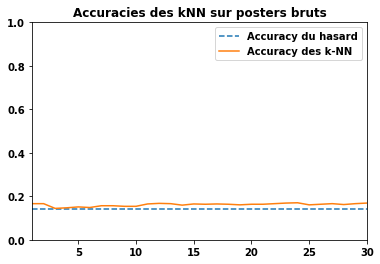

In [5]:
list_k = np.arange(1, 31, 1)
#print(list_k)
visu_acc_knn(list_k, train_posters_norm, train_genres, test_posters_norm, test_genres)


Affichage de la matrice de confusion

## PCA 2D

In [ ]:
import matplotlib.pyplot as plt

def display2D(X_ortho, Y):
    colors = Y.argmax(axis=1)
    
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_ortho[:, 0], X_ortho[:, 1], c=colors)
    plt.legend(*scatter.legend_elements())
    
    plt.show(fig)

In [ ]:
pca = PCA(n_components=2)
# pca.fit(train_posters.reshape(len(train_posters), -1))

train_pca = pca.transform(train_posters.reshape(len(train_posters), -1))
# test_pca = pca.transform(test_posters.reshape(len(train_posters), -1))

display2D(train_pca, train_genres)
display2D(train_resnet_pca[:, :2], train_genres)

#Attention: l'erreur dans la VM vient de la version de matplotlib; et upgrade vers matplotlib 3.1.X pas possible
#Changer version Python...